## DJIA Stock Time Series Analysis ##
By: Sureet Sarau, Erik Martin, Ishraq Rahman

### Data ###
We will be using the [DJIA 30 Stock Time Series Dataset](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231/data?select=all_stocks_2006-01-01_to_2018-01-01.csv) from Kaggle.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from statsmodels.tsa.seasonal import seasonal_decompose

### Data Cleaning and Exploration ###

Retrieve stock data from Apple (AAPL), Amazon (AMZN), Google (GOOGL), IBM (IBM), and Microsoft (MSFT).

In [2]:
# Initialize
output_file = "data/tech_stocks.csv"
tech_stock_codes = ['AAPL', 'AMZN', 'GOOGL', 'IBM', 'MSFT']

# Read in all stocks
all_stocks = pd.read_csv("data/all_stocks_2006-01-01_to_2018-01-01.csv")

# Filter for relevant stocks and save to a file
tech_stocks = all_stocks[all_stocks['Name'].isin(tech_stock_codes)]
tech_stocks.to_csv(output_file, index=False)


### Load and Transform Data ###

In [3]:
# Read in file
tech_df = pd.read_csv("data/tech_stocks_saved.csv")
# Filter out unneeded features
tech_df = tech_df.drop(columns=["Open", "High", "Low", "Volume"])
# Set Date as datetime
tech_df["Date"] = pd.to_datetime(tech_df["Date"])
# Pivot
tech_df = tech_df.pivot(index="Date", columns="Name", values="Close")
# Drop NaN values
tech_df = tech_df.dropna()
# Check dataframe
tech_df


Name,AAPL,AMZN,GOOGL,IBM,MSFT
Date,,,,,
2006-01-03,10.68,47.58,217.83,82.06,26.84
2006-01-04,10.71,47.25,222.84,81.95,26.97
2006-01-05,10.63,47.65,225.85,82.50,26.99
2006-01-06,10.90,47.87,233.06,84.95,26.91
2006-01-09,10.86,47.08,233.68,83.73,26.86
...,...,...,...,...,...
2017-12-22,175.01,1168.36,1068.86,152.50,85.51
2017-12-26,170.57,1176.76,1065.85,152.83,85.40
2017-12-27,170.60,1182.26,1060.20,153.13,85.71


### Visualize Raw Data ###

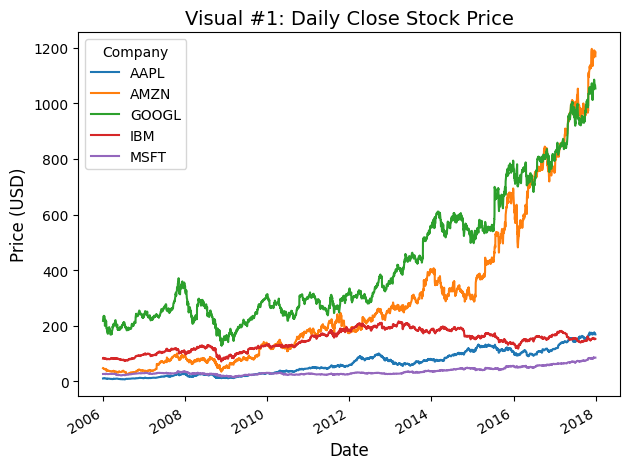

In [4]:
tech_df.plot(ax=plt.gca())
plt.title("Visual #1: Daily Close Stock Price", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(title="Company", fontsize=10)
plt.tight_layout()
plt.show()

# Analysis: Time Series Similarity #

### Gather Seasonality Components ###

In [5]:
def seasonality_decomp(df, model="additive"):
    """Helper function to extract additive seasonality of each tech stock"""
    # Normalize to weekly bins
    weekly = df.resample("W").mean()
    # Iterate through each company
    for company in weekly.columns:
        # Calculate additive seasonal decomposition for annual period
        result = seasonal_decompose(weekly[company], model=model, period=52)
        weekly[company] = result.seasonal
    return weekly

### Visualize Seasonality ###

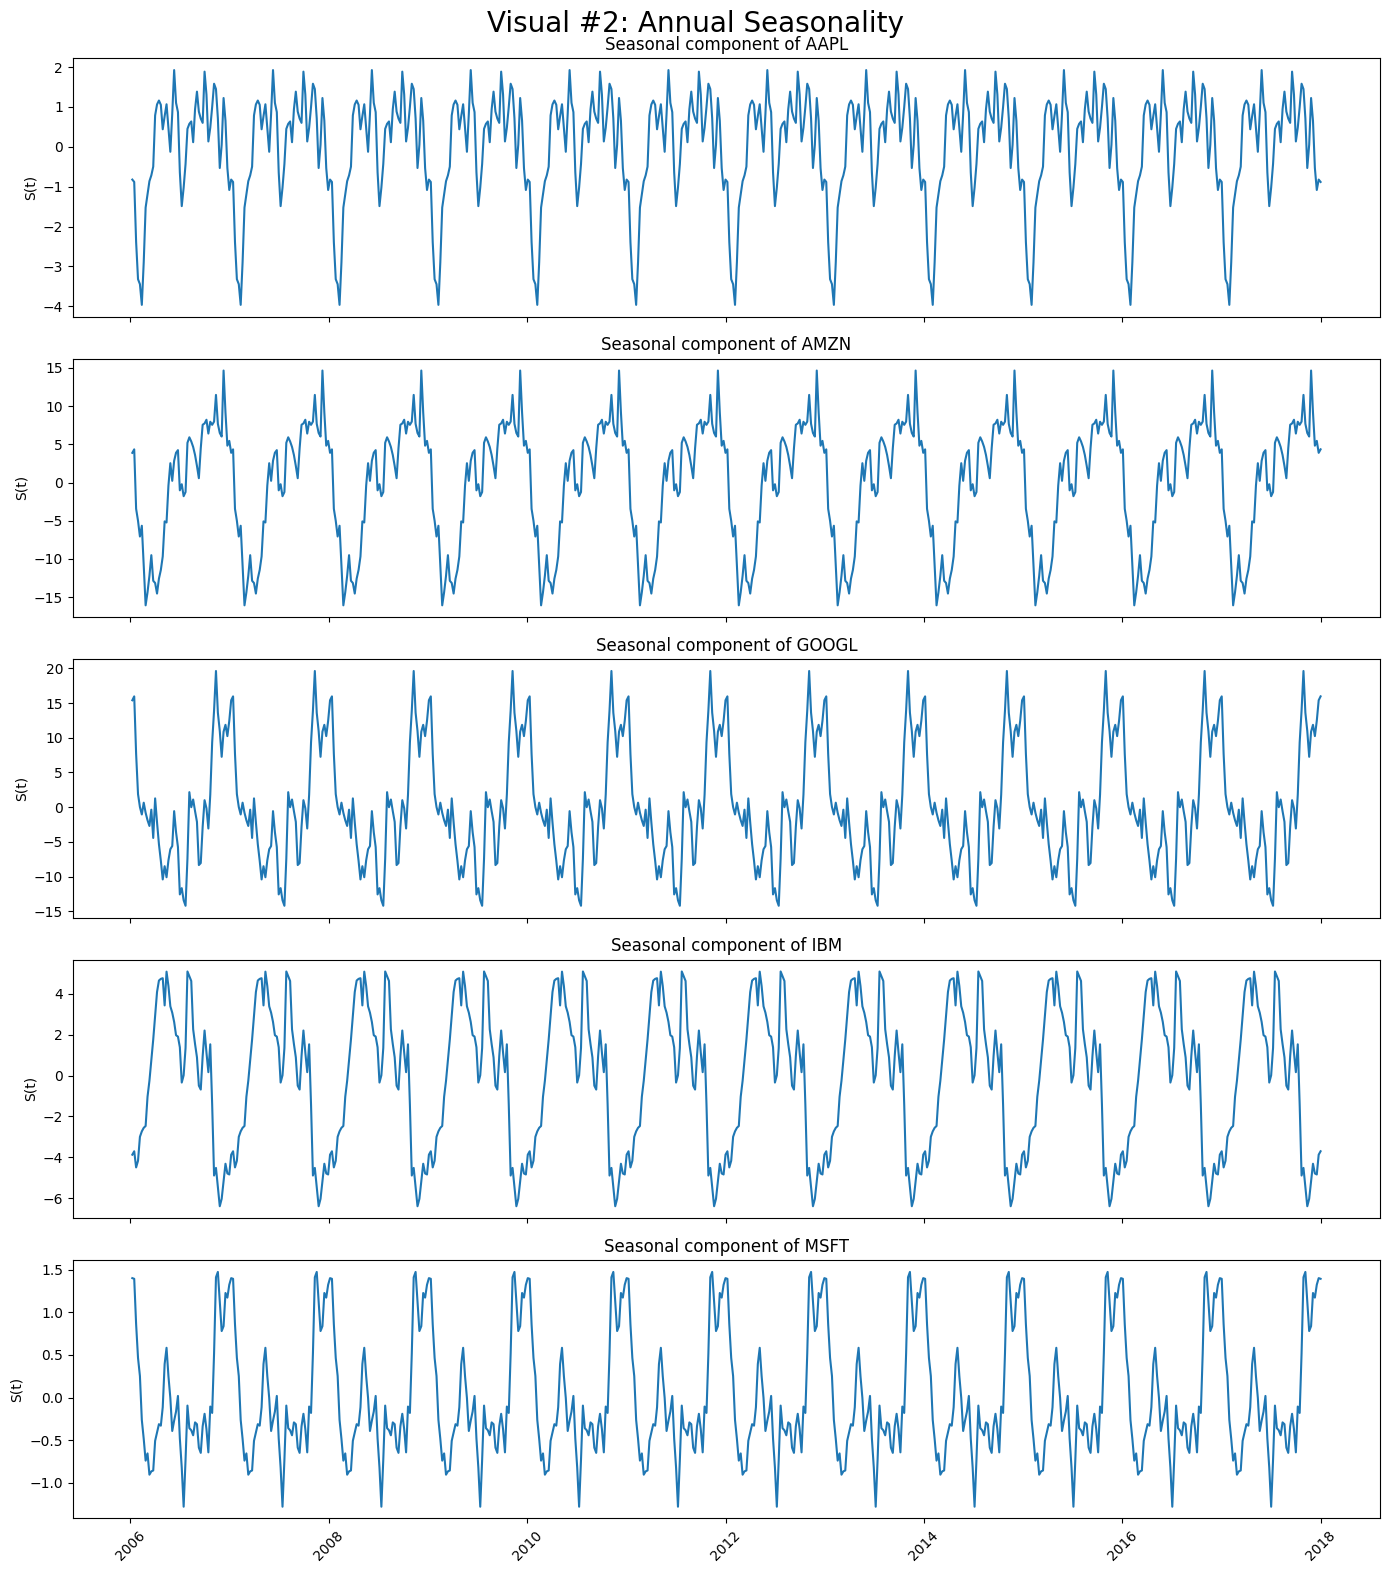

In [6]:
copy_df = tech_df.copy()
seasonal_df = seasonality_decomp(tech_df)

fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)
fig.suptitle("Visual #2: Annual Seasonality", fontsize=20)

for ax, stock in zip(axs, seasonal_df.columns):
    ax.plot(seasonal_df.index, seasonal_df[stock])
    ax.set_title(f"Seasonal component of {stock}")
    ax.set_ylabel("S(t)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Calculate Euclidean Distance ###

In [7]:
def calc_euclidean_dist(df):
    """Helper function to calculate Euclidean Distance of Seasonal df"""
    # initialize euclidean matrix & other variables
    countries = df.columns
    n = len(countries)
    dist_df = pd.DataFrame(np.zeros((n, n)), index=countries, columns=countries)

    # for each country pair
    for i in range(len(countries)):
        for j in range(len(countries)):
            # calc euclidean distance
            diff = df[countries[i]] - df[countries[j]]
            sq_sum = np.sum(diff ** 2)
            # place in matrix
            dist_df.iloc[i, j] = math.sqrt(sq_sum)

    return dist_df

In [8]:
print("Table #1: Euclidean Distance\n")
calc_euclidean_dist(seasonal_df)

Table #1: Euclidean Distance



Name,AAPL,AMZN,GOOGL,IBM,MSFT
Name,,,,,
AAPL,0.000000,185.125182,211.607637,78.837949,38.487802
AMZN,185.125182,0.000000,212.424465,236.798398,188.213370
GOOGL,211.607637,212.424465,0.000000,277.646919,195.076845
IBM,78.837949,236.798398,277.646919,0.000000,98.438385
MSFT,38.487802,188.213370,195.076845,98.438385,0.000000


### Calculate Cosine Similarity ###

In [9]:
def calc_cos_sim(df):
    """Helper function to calculate cosine similarity in a seasonality df"""
    # initialize cosine matrix & other variables
    countries = df.columns
    n = len(countries)
    sim_df = pd.DataFrame(np.zeros((n, n)), index=countries, columns=countries)

    # for each country pair
    for i in range(n):
        for j in range(n):
            # get vector
            x = df[countries[i]]
            y = df[countries[j]]
            # calculate dot product
            dot = np.sum(x * y)
            # calc magnitude
            x_mag = math.sqrt(np.sum(x ** 2))
            y_mag = math.sqrt(np.sum(y ** 2))
            # calc similarity
            cos_sim = dot / (x_mag * y_mag)
            # place in matrix
            sim_df.iloc[i, j] = cos_sim

    return sim_df

In [10]:
print("Table #2: Cosine Similarity\n")
calc_cos_sim(seasonal_df)

Table #2: Cosine Similarity



Name,AAPL,AMZN,GOOGL,IBM,MSFT
Name,,,,,
AAPL,1.000000,0.395573,-0.008400,0.416229,0.005144
AMZN,0.395573,1.000000,0.449840,-0.299310,0.465860
GOOGL,-0.008400,0.449840,1.000000,-0.721296,0.766076
IBM,0.416229,-0.299310,-0.721296,1.000000,-0.591698
MSFT,0.005144,0.465860,0.766076,-0.591698,1.000000


### Conduct Dynamic Time Warping ###

In [11]:
def calc_pairwise_dtw_cost(x, y, ret_matrix=False):
    """Helper function to calculate pairwise distance between stocks"""
    # initialize i
    # uts and dtw_matrix
    x = np.array(x)
    y = np.array(y)
    n, m = len(x), len(y)
    dtw_matrix = np.full((m, n), np.inf)

    # loop through every cell in matrix
    for row in range(m):
        for col in range(n):
            cost = (x[col] - y[row]) ** 2
            # intialize
            if col == 0 and row == 0:
                dtw_matrix[row, col] = cost
            else:
                # get values
                left = dtw_matrix[row, col - 1]
                up = dtw_matrix[row - 1, col]
                diag = dtw_matrix[row - 1, col - 1]
                # apply cost based on min value
                dtw_matrix[row, col] = cost + min(left, up, diag)

    if ret_matrix:
        return dtw_matrix
    else:
        return dtw_matrix[m - 1][n - 1]

def calc_dtw_cost(df):
    """Create df of pairwise DTW values"""
    # Initialize dataframe
    countries = df.columns
    n = len(countries)
    dtw_df = pd.DataFrame(np.zeros((n, n)), index=countries, columns=countries)

    # for each country pair, compute distance
    for i in range(n):
        for j in range(n):
            x = df[countries[i]].values
            y = df[countries[j]].values
            dtw_df.iloc[i, j] = calc_pairwise_dtw_cost(x, y)

    return dtw_df

In [12]:
print("Table #3: DTW Values\n")
np.sqrt(calc_dtw_cost(tech_df.copy()))

Table #3: DTW Values



Name,AAPL,AMZN,GOOGL,IBM,MSFT
Name,,,,,
AAPL,0.000000,16399.339015,19973.289886,2100.262000,1269.890241
AMZN,16399.339015,0.000000,3718.339730,16550.245339,19288.378756
GOOGL,19973.289886,3718.339730,0.000000,19078.906057,23543.287517
IBM,2100.262000,16550.245339,19078.906057,0.000000,4423.289599
MSFT,1269.890241,19288.378756,23543.287517,4423.289599,0.000000


# Analysis: Forecasting #